# Migrating from RefineDocumentsChain

[RefineDocumentsChain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.refine.RefineDocumentsChain.html) implements a strategy for analyzing long texts. The strategy is as follows:

- Split a text into smaller documents;
- Apply a process to the first document;
- Refine or update the result based on the next document;
- Repeat through the sequence of documents until finished.

A common process applied in this context is summarization, in which a running summary is modified as we proceed through chunks of a long text. This is particularly useful for texts that are large compared to the context window of a given LLM.

A [LangGraph](https://langchain-ai.github.io/langgraph/) implementation confers a number of advantages for this problem:

- Where `RefineDocumentsChain` refines the summary via a `for` loop inside the class, a LangGraph implementation lets you step through the execution to monitor or otherwise steer it if needed.
- The LangGraph implementation supports streaming of both execution steps and individual tokens.
- Because it is assembled from modular components, it is also simple to extend or modify (e.g., to incorporate [tool calling](/docs/concepts/tool_calling) or other behavior).

Below we will go through both `RefineDocumentsChain` and a corresponding LangGraph implementation on a simple example for illustrative purposes.

Let's first load a chat model:

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [1]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Example

Let's go through an example where we summarize a sequence of documents. We first generate some simple documents for illustrative purposes:

In [2]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

### Legacy

<details open>

Below we show an implementation with `RefineDocumentsChain`. We define the prompt templates for the initial summarization and successive refinements, instantiate separate [LLMChain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.llm.LLMChain.html) objects for these two purposes, and instantiate `RefineDocumentsChain` with these components.

In [4]:
from langchain.chains import LLMChain, RefineDocumentsChain
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_openai import ChatOpenAI

# This controls how each document will be formatted. Specifically,
# it will be passed to `format_document` - see that function for more
# details.
document_prompt = PromptTemplate(
    input_variables=["page_content"], template="{page_content}"
)
document_variable_name = "context"
# The prompt here should take as an input variable the
# `document_variable_name`
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_llm_chain = LLMChain(llm=llm, prompt=summarize_prompt)
initial_response_name = "existing_answer"
# The prompt here should take as an input variable the
# `document_variable_name` as well as `initial_response_name`
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])
refine_llm_chain = LLMChain(llm=llm, prompt=refine_prompt)
chain = RefineDocumentsChain(
    initial_llm_chain=initial_llm_chain,
    refine_llm_chain=refine_llm_chain,
    document_prompt=document_prompt,
    document_variable_name=document_variable_name,
    initial_response_name=initial_response_name,
)

We can now invoke our chain:

In [5]:
result = chain.invoke(documents)
result["output_text"]

'Apples are typically red in color, blueberries are blue, and bananas are yellow.'

The [LangSmith trace](https://smith.langchain.com/public/8ec51479-9420-412f-bb21-cb8c9f59dfde/r) is composed of three LLM calls: one for the initial summary, and two more updates of that summary. The process completes when we update the summary with content from the final document.

</details>

### LangGraph

<details open>

Below we show a LangGraph implementation of this process:

- We use the same two templates as before.
- We generate a simple chain for the initial summary that plucks out the first document, formats it into a prompt and runs inference with our LLM.
- We generate a second `refine_summary_chain` that operates on each successive document, refining the initial summary.

We will need to install `langgraph`:

In [ ]:
pip install -qU langgraph

In [4]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# For LangGraph, we will define the state of the graph to hold the query,
# destination, and final answer.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

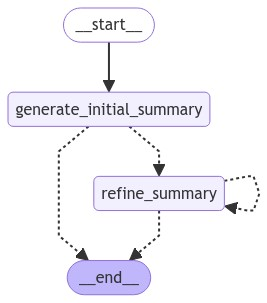

In [5]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

We can step through the execution as follows, printing out the summary as it is refined:

In [6]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)

Apples are typically red in color.
Apples are typically red in color, while blueberries are blue.
Apples are typically red in color, blueberries are blue, and bananas are yellow.


In the [LangSmith trace](https://smith.langchain.com/public/d6656f49-4fa1-44b9-b6d3-10af921037fa/r) we again recover three LLM calls, performing the same functions as before.

Note that we can stream tokens from the application, including from intermediate steps:

In [8]:
async for event in app.astream_events(
    {"contents": [doc.page_content for doc in documents]}, version="v2"
):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            print(content, end="|")
    elif kind == "on_chat_model_end":
        print("\n\n")

Ap|ples| are| characterized| by| their| red| color|.|


Ap|ples| are| characterized| by| their| red| color|,| while| blueberries| are| known| for| their| blue| hue|.|


Ap|ples| are| characterized| by| their| red| color|,| blueberries| are| known| for| their| blue| hue|,| and| bananas| are| recognized| for| their| yellow| color|.|




</details>

## Next steps

See [this tutorial](/docs/tutorials/summarization/) for more LLM-based summarization strategies.

Check out the [LangGraph documentation](https://langchain-ai.github.io/langgraph/) for detail on building with LangGraph.